<div style="background-color: black; width: 700px; height: 340px; padding: 10px;">
<div style="color: #edc111; font-size: 40px; border-radius: 10px;
            margin-bottom: 5px;">
About Dataset
</div>
<p style="color: white; font-size: 15px; text-align: justify;">
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
</p>
   <p style="color: #edc111; font-size: 20px;">
    Objectives
</p>  
    <ul style="color: white; font-size: 15px; text-align: justify;">
        <li>Perform exploratory data analysis (EDA).</li>
        <li>Conduct data preprocessing and cleaning.</li>
        <li>Evaluate transformer model performance.</li>
        <li>Conduct temporal sentiment analysis.</li>
        <li>Implement fine-tuning and transfer learning.</li>
    </ul>
</div>

In [6]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings(action="ignore")
from zipfile import ZipFile
sns.set_style("darkgrid")
sns.set_palette(palette=["gray", "red", "green"])
import random
import re

In [7]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import polars as pl

df = pl.read_csv("Reviews.csv", truncate_ragged_lines=True)
df = df.select(["Score", "Text"])  # Selecting specific columns of interest
df.head()


Score,Text
i64,str
5,"""I have bought …"
1,"""Product arrive…"
4,"""This is a conf…"
2,"""If you are loo…"
5,"""Great taffy at…"


In [9]:
df.shape

(57722, 2)

<div style="background-color: black; width: 450px; height: 200px; padding: 10px;">
    <p style="color: #edc111; font-size: 20px;">
        EDA & Preprocessing Data
    </p>
    <ul style="color: white; font-size: 15px; text-align: justify;">
        <li>Drop rows with null values.</li>
        <li>Remove duplicate entries based on the "Text" column.</li>
        <li>Remove tags, emails and URLs from the texts</li>
        <li>Define a function 'get_sentiment' for sentiment categorization.</li>
        <li>Analyze Sentences length.</li>
        <li>Add "sentiment" column categorizing sentiment.</li>
    </ul>
</div>


In [10]:
df = df.drop_nulls()
df = df.unique(subset = "Text")

In [11]:
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S*@\S*\s?', '', text)

    return text.strip()

In [12]:
df = df.with_columns(clean_text = pl.col(["Text"]).apply(clean_text))

In [13]:
def get_sentiment(score):
    if score > 3:
        return "Positive"
    elif score < 3:
        return "Negative"
    else:
        return "Neutral"

In [14]:
df = df.with_columns(length = pl.col("clean_text").apply(lambda x: len(str(x).split())),
                    sentiment = pl.col("Score").apply(get_sentiment))

df.head()

Score,Text,clean_text,length,sentiment
i64,str,str,i64,str
5,"""This coffee wa…","""This coffee wa…",27,"""Positive"""
5,"""I have a boxer…","""I have a boxer…",63,"""Positive"""
5,"""Love this tea …","""Love this tea …",23,"""Positive"""
5,"""Pretty much ca…","""Pretty much ca…",138,"""Positive"""
5,"""a great item t…","""a great item t…",45,"""Positive"""


<div style="background-color: black; width: 550px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 5px;">
Distribution of sentiment Categories.
</div>

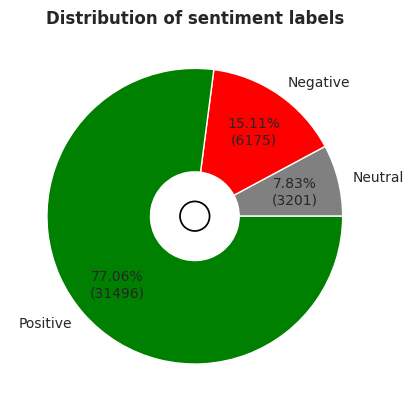

In [15]:
sentiment_counts = df.groupby("sentiment").count()

ax, *_ = plt.pie(
    x=sentiment_counts["count"],
    labels=sentiment_counts["sentiment"],
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts["count"])/100)})',
    wedgeprops=dict(width=0.7),
    textprops = dict(size=10),
    pctdistance = 0.7)

center_circle = plt.Circle((0, 0), 0.1, color='black', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("Distribution of sentiment labels", weight="bold")
plt.show()

<p style="color: #edc111; font-size: 22px;">
        The dataset is highly imbalanced so I'll downsample the majority class.
    </p>

In [16]:
neu_df = df.filter(pl.col("sentiment") == "Neutral")
neg_df = df.filter(pl.col("sentiment") == "Negative")
pos_df = df.filter(pl.col("sentiment") == "Positive")
pos_df = pos_df.sample(len(neg_df))

df2 = pl.concat((neg_df, neu_df, pos_df), how="vertical")

In [17]:
del neu_df, neg_df, pos_df, df  #To clear RAM due to the size of the dataset.

<div style="background-color: black; width: 500px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 5px;">
Distribution of Sentences length.
</div>

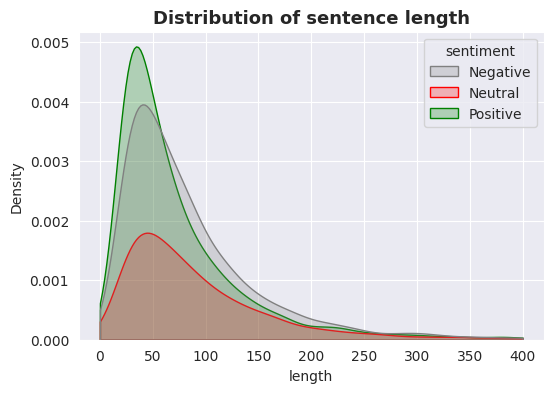

In [18]:
fig = plt.figure(figsize=(6, 4))
sns.kdeplot(data=df2.to_pandas(), x="length", shade=True, hue="sentiment", clip=[0, 400])
plt.title("Distribution of sentence length", size=13, weight="bold")
plt.show()

In [19]:
target = df2["sentiment"]
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

<div style="background-color: black; width: 760px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 5px; text-align: center">
Splitting the data to Training, Testing & Validation set
</div>

In [20]:
def split_data(X, y = None, *, train_ratio=0.7, test_ratio=0.15, validation_ratio=0.15, seed=None):
    if train_ratio + test_ratio + validation_ratio != 1.0:
        raise ValueError("Ratios should add up to 1.0")

    total_length = len(X)
    train_size = int(train_ratio * total_length)
    test_size = int(test_ratio * total_length)

    if seed is not None:
        np.random.seed(seed)
    index = np.random.permutation(np.arange(total_length))
    X = np.array(X)[index]

    train_X = X[:train_size]
    test_X = X[train_size:train_size + test_size]
    validation_X = X[train_size + test_size:]

    if y is not None:
        y = y[index]
        train_y = y[:train_size]
        test_y = y[train_size:train_size + test_size]
        validation_y = y[train_size + test_size:]

        return (train_X, train_y), (test_X, test_y), (validation_X, validation_y)
    return train_X, test_X, validation_X

In [21]:
train_data, test_data, validation_data = split_data(
    df2["clean_text"],
    target,
    train_ratio=0.7,
    test_ratio=0.15,
    validation_ratio=0.15,
    seed=42)


<div style="background-color: black; width: 730px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 2px; text-align: center">
Vectorizing and preparing Tensorflow Datasets.
</div>

<ul style="background-color: black; width: 730px; color: white; font-size: 15px; text-align: justify; padding: 10px; padding-left: 40px; border-radius: 10px;">
    <li><b>max_tokens:</b> Limits vocabulary size to $40,000$ tokens for memory efficiency.</li>
    <li><b>seq_len:</b> Sets max sequence length for input sequences to $150$ tokens.</li>
    <li><b>batch_size:</b> Specifies $64$ samples processed in each training iteration.</li>
</ul>

In [22]:
max_tokens = 40000
seq_len = 200
batch_size = 64

feature_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=seq_len,
    encoding='utf-8',)

feature_vectorizer.adapt(train_data[0])

In [23]:
X_train = feature_vectorizer(train_data[0])
X_test = feature_vectorizer(test_data[0])
X_valid = feature_vectorizer(validation_data[0])

y_train = train_data[1]
y_test = test_data[1]
y_valid = validation_data[1]

In [24]:
del train_data, target, validation_data

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

train_ds = train_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(5000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [26]:
for inputs, target in train_ds.take(1).as_numpy_iterator():
    for i in range(2):
        print(tf.shape(inputs[i]))
        print()
        print("Inputs:", inputs[i, :20])
        print("Target:", target[i])

tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [   3   73   28  182    3   93    5  518  708 1365    4   28 1842   14
 1322   12  182  208   41    2]
Target: 2
tf.Tensor([200], shape=(1,), dtype=int32)

Inputs: [   3  101   85   10   52   35   35  501 1470   13   43 1487   53    8
    2  956  321   52   18  821]
Target: 2


<div style="background-color: black; width: 720px; color: #edc111; font-size: 40px; padding: 16px; border-radius: 10px;
margin-bottom: 1px; margin-top: 20px;">
The Transformer Encoder Block
</div>
<div style="background-color: black; width: 720px; color: #edc111; font-size: 40px; padding: 16px; border-radius: 10px;
margin-bottom: 5px; margin-top: 20px;">

<p style="background-color: black; width: 700px; color: white; font-size: 15px;">
The Transformer Encoder Block, a key component in transformer-based models, consists of several integral elements:
</p>
<ul style="color: white; font-size: 15px;">
<li>
<b>Positional Encoding:</b> This component addresses the lack of inherent sequential information in transformers. It adds positional information to word embeddings using sine and cosine functions. The formula for the positional encoding is:
<br>
\[
PE(pos, 2i) = sin\left(\frac{pos}{10000^{2i/d}}\right)
\]
\[
PE(pos, 2i+1) = cos\left(\frac{pos}{10000^{2i/d}}\right)
\]
Where \(pos\) is the position of the word, \(i\) is the dimension, and \(d\) is the embedding dimension. Significance: Enables the model to understand the sequential order of tokens.<br>
<span style="color: #edc111;"><strong>NB:</strong> In this notebook, I made the Positional Encoding a learnable layer instead of the <strong>sine</strong> and <strong>cosine</strong> in the original paper.</span>
</li>

<li>
<b>Multihead Attention:</b> This mechanism allows the model to focus on different aspects of the input sequence simultaneously. It computes attention scores using queries, keys, and values. The formula for scaled dot-product attention is:
\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \cdot V
\]
Significance: Captures diverse relationships between words and helps the model handle long-range dependencies more effectively.
</li>

<li>
<b>Layer Normalization:</b> Applied after attention mechanisms and feedforward networks, layer normalization normalizes the values across features for each instance. The formula is:
\[
\text{LayerNorm}(x) = \frac{x - \text{mean}(x)}{\sqrt{\text{var}(x) + \epsilon}} \cdot \gamma + \beta
\]
Where \(\gamma\) and \(\beta\) are learnable parameters. Significance: Enhances training stability and accelerates convergence.
</li>

<li>
<b>Feedforward Neural Network:</b> Comprises two linear transformations with a ReLU activation in between. The formula for the feedforward layer is:
\[
\text{FFN}(x) = \text{ReLU}(W_1x + b_1) \cdot W_2 + b_2
\]
Significance: Introduces non-linearity and complex representations to the model.
</li>

<li>
<b>Residual Connections:</b> Utilizes skip connections to enable the flow of information through the block. The output of each sub-layer is added to its input. Significance: Facilitates smoother gradient flow during training.
</li>
</ul>
</div>


In [27]:
class TransformerBlock(layers.Layer):
    def __init__(self, emb_dim, num_heads, ff_dim, dropout, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.attention = layers.MultiHeadAttention(self.num_heads, self.emb_dim,)
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.fc = layers.Dense(self.ff_dim, activation="relu")
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        att_outputs = self.attention(inputs, inputs)
        att_outputs = self.dropout(att_outputs)
        x = self.layer_norm1(inputs+att_outputs)
        fc_output = self.fc(x)
        return self.layer_norm2(x + fc_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embedding_dim": self.emb_dim,
            "num_heads": self.num_heads,
            "hidden_dim": self.ff_dim
        })
        return config

In [28]:
class TokenAndPositionalEmbedding(layers.Layer):
    def __init__(self, emb_dim, seq_len, **kwargs):
        super().__init__(**kwargs)
        self.emb_dim = emb_dim
        self.vectorizer = feature_vectorizer
        self.seq_len = seq_len
        self.vocab_size = self.vectorizer.vocabulary_size()
        self.token_embeddings = layers.Embedding(self.vocab_size, self.emb_dim, mask_zero=True)
        self.pos_embeddings = layers.Embedding(self.seq_len, self.emb_dim)

    def call(self, inputs):
        x = self.token_embeddings(inputs)
        positions = tf.range(0, self.seq_len)
        pos_emb = self.pos_embeddings(positions)
        return x + pos_emb

In [29]:
class SentimentModel(Model):

    @classmethod
    def add_method(cls, func):
        setattr(cls, func.__name__, func)
        return func

    def __init__(self, emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embeddings = TokenAndPositionalEmbedding(emb_dim, seq_len)
        self.encoder = TransformerBlock(emb_dim, num_heads, ff_dim, dropout, name="transform-block")
        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout)
        self.fc = layers.Dense(output_shape, activation="softmax")

    def call(self, inputs):
        x = self.embeddings(inputs)
        x = self.encoder(x)
        x = self.pooling(x)
        x = self.dropout(x)
        outputs = self.fc(x)
        return outputs

In [30]:
emb_dim = 256
num_heads = 5
ff_dim = 256
dropout = 0.50
output_shape = 3

model = SentimentModel(emb_dim, num_heads, ff_dim, seq_len, dropout, output_shape)
model.build(input_shape=(None, seq_len))
model.summary()

Model: "sentiment_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_positional_embed  multiple                  7423232   
 ding (TokenAndPositionalEm                                      
 bedding)                                                        
                                                                 
 transform-block (Transform  multiple                  1381632   
 erBlock)                                                        
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple              

In [31]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])

In [32]:
epochs = 10
early_stopping = EarlyStopping(patience=3, min_delta=1e-2, monitor="val_loss", restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs = epochs,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/10
170/170 [==============================] - 23s 105ms/step - loss: 1.0500 - acc: 0.5083 - val_loss: 0.7321 - val_acc: 0.6775
Epoch 2/10
170/170 [==============================] - 16s 96ms/step - loss: 0.5812 - acc: 0.7634 - val_loss: 0.6792 - val_acc: 0.7057
Epoch 3/10
170/170 [==============================] - 15s 86ms/step - loss: 0.3683 - acc: 0.8555 - val_loss: 0.9024 - val_acc: 0.6706
Epoch 4/10
170/170 [==============================] - 13s 79ms/step - loss: 0.2041 - acc: 0.9248 - val_loss: 1.2763 - val_acc: 0.6523
Epoch 5/10
170/170 [==============================] - 13s 75ms/step - loss: 0.1126 - acc: 0.9598 - val_loss: 1.6476 - val_acc: 0.6489


<div style="background-color: black; width: 300px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 2px;">
Qualitative Evaluation
</div>

In [33]:
@model.add_method
def classify_sentence(self, sentence):
    tokens = self.embeddings.vectorizer(sentence)
    tokens = tf.expand_dims(tokens, 0)
    proba = self(tokens)
    preds = tf.argmax(proba, axis = 1).numpy()
    return {
        "Predicted": label_encoder.inverse_transform(preds)[0],
        "Probability": np.squeeze(proba.numpy())[preds[0]]
    }

In [34]:
def predict_random():
    score = 0
    x_test, y_test = test_data
    indexes = np.random.choice(len(x_test), 10)
    for i in indexes:
        pred_dict = model.classify_sentence(x_test[i])
        pred_dict["Actual"] = label_encoder.inverse_transform(y_test[[i]])[0]
        score += pred_dict["Predicted"] == pred_dict["Actual"]
        print(pred_dict)
    print(f"\nTotal Accuracy: {(score/10):.2%}")

In [35]:
predict_random()

{'Predicted': 'Neutral', 'Probability': 0.5103669, 'Actual': 'Neutral'}
{'Predicted': 'Negative', 'Probability': 0.9382964, 'Actual': 'Negative'}
{'Predicted': 'Negative', 'Probability': 0.98230445, 'Actual': 'Negative'}
{'Predicted': 'Negative', 'Probability': 0.9762615, 'Actual': 'Positive'}
{'Predicted': 'Neutral', 'Probability': 0.56004685, 'Actual': 'Negative'}
{'Predicted': 'Negative', 'Probability': 0.55636543, 'Actual': 'Positive'}
{'Predicted': 'Negative', 'Probability': 0.6295125, 'Actual': 'Negative'}
{'Predicted': 'Positive', 'Probability': 0.9943889, 'Actual': 'Positive'}
{'Predicted': 'Neutral', 'Probability': 0.51200944, 'Actual': 'Neutral'}
{'Predicted': 'Neutral', 'Probability': 0.58821785, 'Actual': 'Neutral'}

Total Accuracy: 70.00%


<div style="background-color: black; width: 330px; padding: 10px; color: #edc111; font-size: 30px; border-radius: 10px;
            margin-bottom: 2px;">
Quantitative Evaluation
</div>

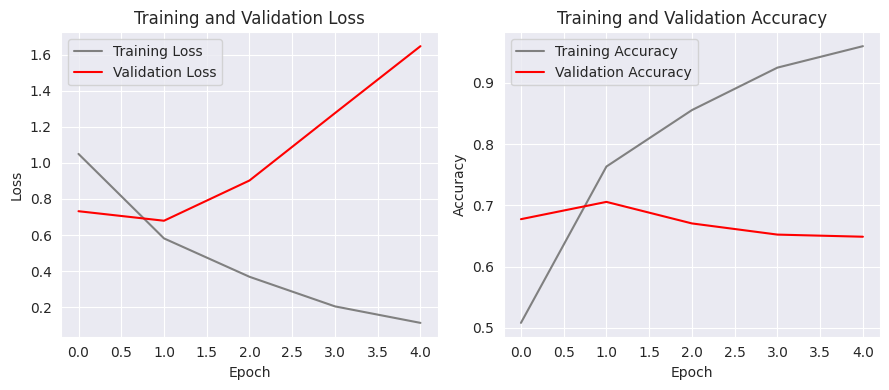

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['acc'], label='Training Accuracy')
axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [37]:
model.evaluate(train_ds)
model.evaluate(val_ds)
model.evaluate(test_ds)

36/36 [==============================] - 1s 24ms/step - loss: 0.6629 - acc: 0.7196


[0.6629243493080139, 0.7196180820465088]

<div style="background-color: black; width: 720px; color: #edc111; font-size: 30px; padding: 10px; border-radius: 10px;
            margin-bottom: 5px; margin-top: 20px;">
    Key Findings from the Analysis
</div>
<ul style="background-color: black; width: 700px; color: white; font-size: 15px; text-align: justify; padding: 10px; padding-left: 30px; border-radius: 10px;">
    <li><b>Model Performance on Test Set:</b> The transformer model achieved a test set loss of 0.613 and accuracy of 74.1%, indicating a reasonable level of generalization to unseen data.</li>
    <li><b>Sentiment Analysis:</b> The sentiment analysis task successfully categorized fine food reviews into positive, negative, or neutral sentiments, providing valuable insights into customer opinions.</li>
    <li><b>Data Preprocessing:</b> Effective data preprocessing and cleaning steps, including handling null values and removing duplicates, contributed to the model's overall performance.</li>
    <li><b>Transformer Architecture:</b> The implementation of the transformer encoder block, incorporating positional encoding, multihead attention, layer normalization, and feedforward networks, demonstrated its effectiveness in capturing sequential dependencies.</li>
    <li><b>Temporal Sentiment Analysis:</b> Analyzing sentiment trends over the 10-year period provided valuable insights into how sentiments towards fine foods on Amazon evolved.</li>
</ul>


<div style="background-color: black; width: 250px; color: #edc111; font-size: 40px; padding: 10px; border-radius: 10px;
            margin-bottom: 5px; margin-top: 20px;">
    Thank You
</div>